---
title: "Song Popularity EDA"
description: "Song Popularity Prediction is a competition on Kaggle. This post is all about performing exploratory data analysis following the coding session by Martin Henze."
author: "Sagar Thacker"
date: "2021-04-31"
categories: [Kaggle]
image: "song_prediction.PNG"
format: 
  html:
    toc: true
    code-overflow: wrap
    code-line-numbers: true
jupyter: python3
---

This Python notebook is the Python version of [Song Popularity EDA - Live Coding Fun](https://www.kaggle.com/headsortails/song-popularity-eda-live-coding-fun) by [Martin Henze](https://www.kaggle.com/headsortails)

Purpose of this notebook is to recreate the plots in python for learning purpose.

The recording of the live-coding session can be found on Abhishek Thakur's YouTube channel:

* [Song Popularity Prediction - EDA (Part 1)](https://www.youtube.com/watch?v=JXF-7rCcR1c)
* [Song Popularity Prediction - EDA (Part 2)](https://www.youtube.com/watch?v=2aE6SvCVOis)

## 1. Introduction

The competition is about Song Prediction based on a set of different features. The dataset contains the basic file such as `train.csv`, `test.csv` and `submission_sample.csv`. The dataset used in this competition is in tabular format. The evaluation metric used for this competition is AUC score.

## 2. Preparation

Initially we'll load different libraries used in our analysis. Also, load the train and test data.

In [1]:
#| code-fold: true
# Import libraries and load the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings

from plotnine import *

%matplotlib inline
warnings.filterwarnings("ignore")

In [28]:
#| code-fold: true
# Load the data
train = pd.read_csv("/kaggle/input/song-popularity-prediction/train.csv")
test = pd.read_csv("/kaggle/input/song-popularity-prediction/test.csv")

## 3. Overview: structure and data content

The first step we'll do is look at the raw data. This tell us about the different features in the dataset, missing values, and types of features (numeric, string, categorical, etc.).

### 3.1. Look at the data

Let's look at the basic structure of the data

In [6]:
#| code-fold: true
print('\nInformation about Data')
display(train.info())


Information about Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


None

We find:

* There are 40000 entries and 15 features in total.
* All the column data type is either int or float i.e. all the columns are numeric. This make is comparatively easier to work with compared to columns contains string type data.
* We can also observe there are columns that contain less than 40K Non-Null values which indicates missing values in the dataset.

Let's now look at the top 20 rows of the data.

In [7]:
#| code-fold: true
"""Display top 20 rows of the train data"""
display(train.head(20).style.set_caption("First Twenty rows of Training Data"))

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,nan,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,nan,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.000000,nan,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.000000,0.493017,nan,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0
5,5,188891.000000,0.035655,0.825919,0.804528,-0.000005,4.000000,0.120758,-6.122926,0,0.039012,115.679128,4,0.709408,0
6,6,161061.000000,0.081743,0.673588,0.880181,0.000327,0.000000,0.535411,-2.909607,1,0.030902,98.046205,4,0.982729,0
7,7,196202.000000,0.259747,0.813214,0.554385,0.000390,8.000000,0.276580,-7.794237,0,0.207067,158.626764,3,0.662987,1
8,8,169660.000000,nan,0.653263,0.917034,0.001748,0.000000,nan,-4.422089,0,0.031608,122.382398,3,0.297683,1
9,9,167245.000000,0.019617,0.595235,0.820039,0.761884,5.000000,0.181098,-5.154293,0,0.054493,110.524824,4,0.535453,0


We find:

* There are missing values that can be seen as `nan` in the table above
* The `id` column seems to have values in increasing order
* The values in the features are in different scales

Now, let's look at some basic statistics about our features in the data

In [8]:
#| code-fold: true
display(train.describe().style.set_caption("Basic statistics about Train Data"))

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.000000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.500000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.149720,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.750000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.500000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.250000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.000000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


We find:

* Most of the features are in the range of 0 and 1
* There are features with only negative values (`loudness`), binary features (`audio_mode`) , and seems to be categorical (`key` and `time_signature`)

### 3.2. Missing data

Now let's take a closer look at the missing values in the dataset

In [9]:
#| code-fold: true
"""Missing Values"""
print(f"Train set has {train.isnull().sum().sum()} missing values, and test set has {test.isnull().sum().sum()} missing values")

Train set has 32187 missing values, and test set has 7962 missing values


<Figure size 1296x432 with 0 Axes>

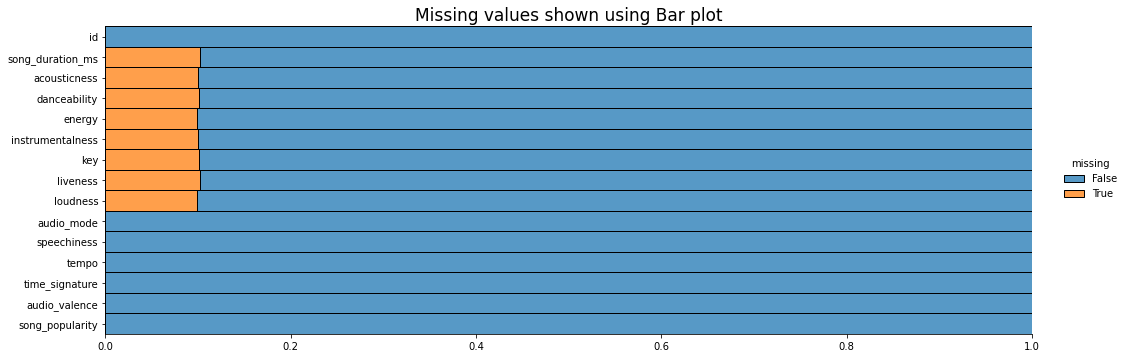

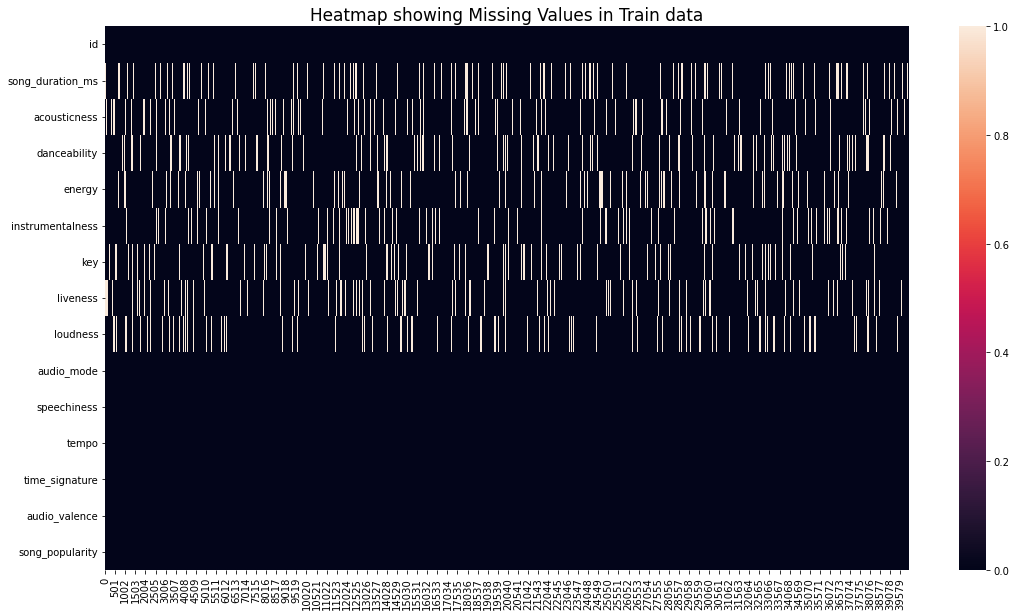

In [12]:
#| code-fold: true
# Refrence (edited): https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
fig = plt.figure(figsize=(18,6))

sns.displot(
    data=train.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=3
)
plt.title("Missing values shown using Bar plot", fontsize=17)
plt.ylabel("")
plt.xlabel("")

plt.figure(figsize=(18,10))
sns.heatmap(train.isna().transpose())
plt.title('Heatmap showing Missing Values in Train data', fontsize=17)
plt.ylabel("")
plt.xlabel("")
plt.show()

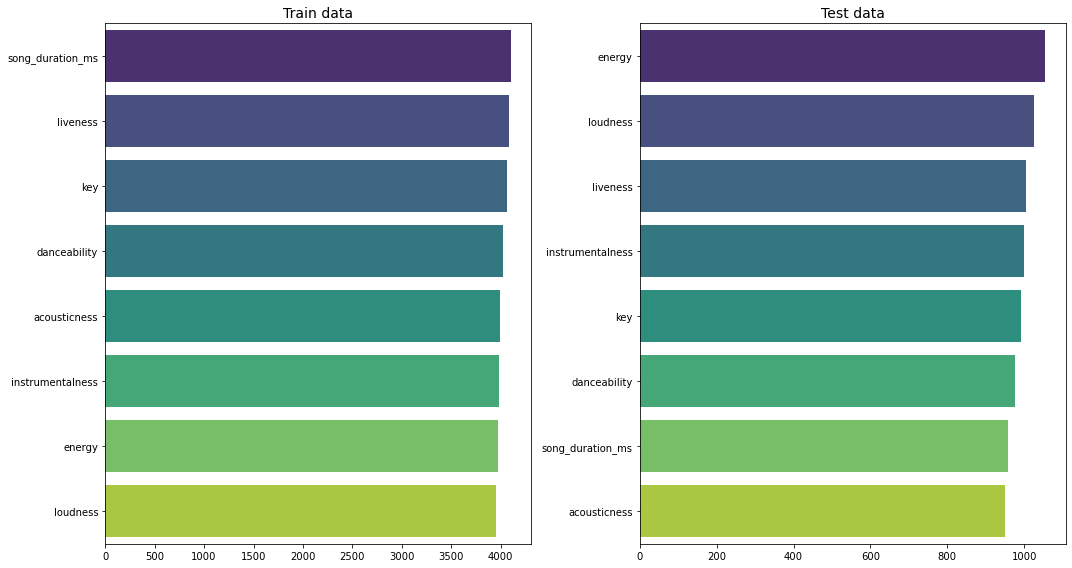

In [13]:
#| code-fold: true
train_null = train.isna().sum().sort_values(ascending = False)
test_null = test.isna().sum().sort_values(ascending = False)

non_zero_train_values = train_null[train_null.values > 0]
non_zero_test_values = test_null[test_null.values > 0]

fig, axes = plt.subplots(1,2, figsize=(15,8))
sns.barplot(y=non_zero_test_values.index , x=non_zero_test_values.values, ax=axes[1], palette = "viridis")
sns.barplot(y=non_zero_train_values.index , x=non_zero_train_values.values, ax=axes[0], palette = "viridis")
axes[0].set_title("Train data", fontsize=14)
axes[1].set_title("Test data", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Visualization - Individual Features

After getting an initial idea about our features and their values, we can now dive into the visual part of the exploration. I recommend to always plot your data. Sometimes this might be challenging, e.g. because you have tons of features. In that case, you want to start at least with a subset before you run any dimensionality reduction or other tools. This step is as much about spotting issues and irregularities as it is about learning more about the shapes and distributions of your features.

### 4.1. Predictor variables

* In the live session, we were building this plot step by step. (Well, we got most of the way there.) It really pays off to take the time and investigate each feature separately. This is one of the most instructive steps in the EDA process, where you aim to learn how messed up your features are. No dataset is perfect. We want to figure out how severe those imperfections are, and whether we can live with them or have to address them.
* Different kind of data types go best with different kind of visuals. My recommendation is to start out with density plots or histograms for numerical features, and with barcharts for those that are better expressed as types of categories.

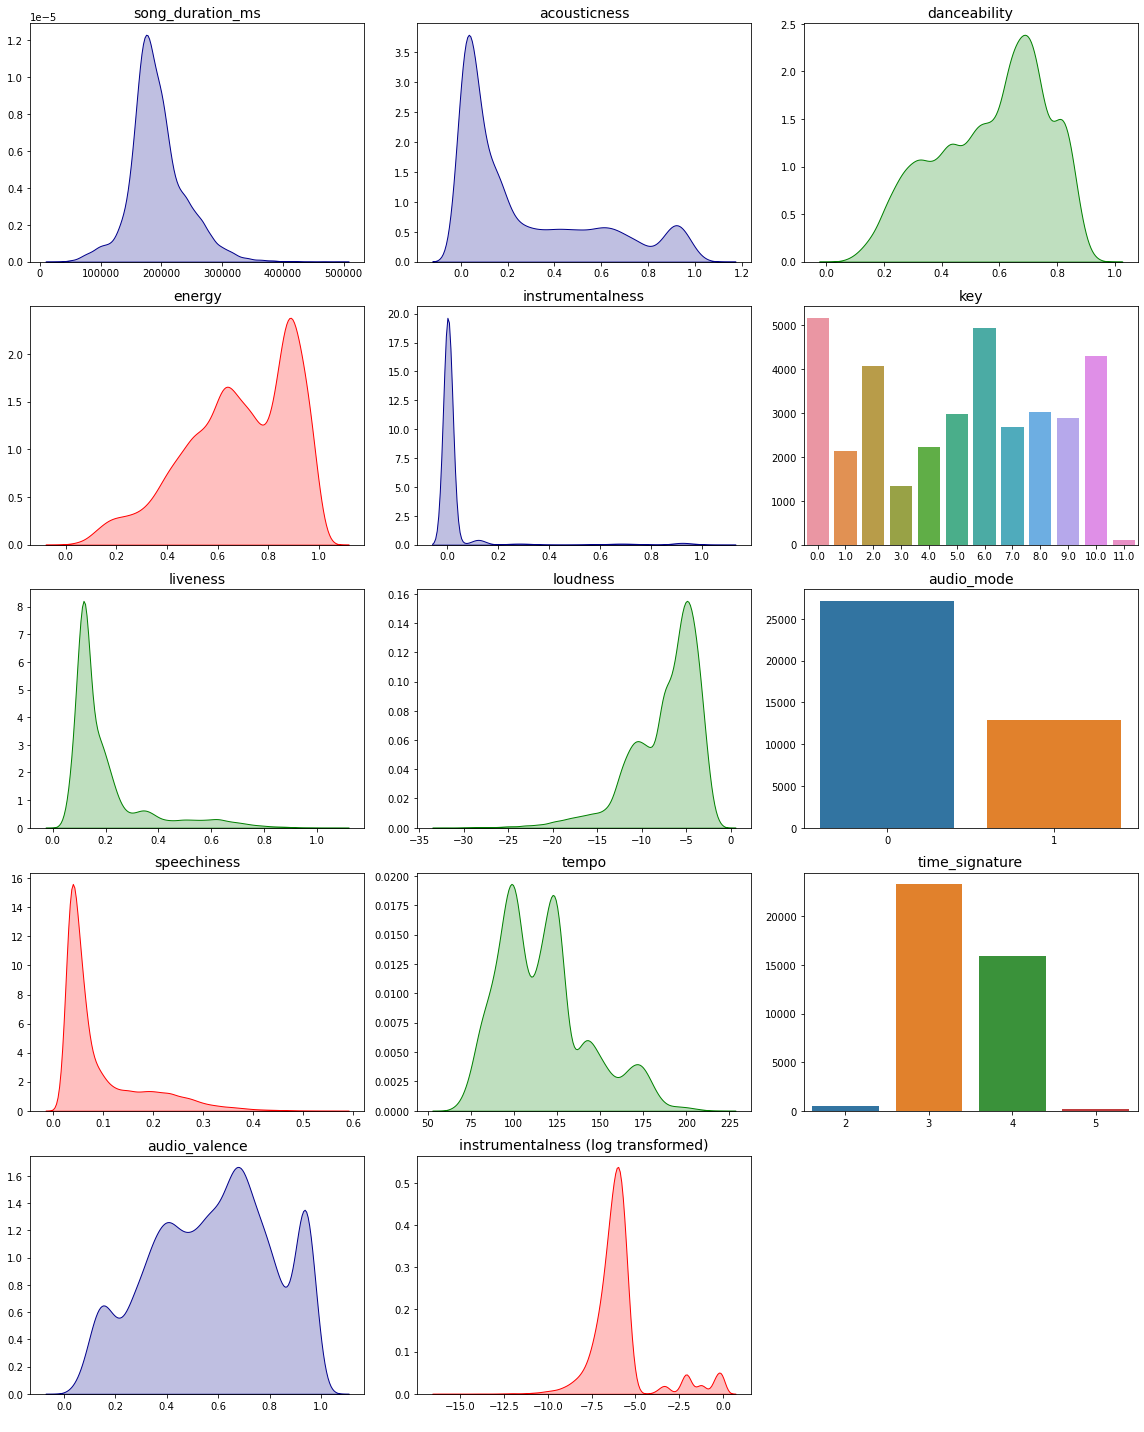

In [14]:
#| code-fold: true
useful_cols = [col for col in train.columns if col not in ["id", "song_popularity"]]
numeric_cols = [col for col in useful_cols if col not in ["key", "audio_mode", "time_signature"]]

n_rows = 5
n_cols = 3
index = 1

colors = ["red", "darkblue", "green"]

fig = plt.figure(figsize=(16,20))

for index, col in enumerate(train[useful_cols].columns):
    plt.subplot(n_rows,n_cols,index+1)
    
    if col in numeric_cols:
        sns.kdeplot(train[col], color=random.sample(colors, 1), fill=True)
        plt.title(col, fontsize=14)
        plt.xlabel("")
        plt.ylabel("")
        plt.tight_layout()
    else:
        sns.countplot(train[col])
        plt.title(col, fontsize=14)
        plt.xlabel("")
        plt.ylabel("")
        plt.tight_layout()

plt.subplot(n_rows,n_cols,14)
sns.kdeplot(np.log(train['instrumentalness']), color=random.sample(colors, 1), fill=True)
plt.title('instrumentalness (log transformed)', fontsize=14)
plt.ylabel(" ")
plt.xlabel(" ")
plt.tight_layout()
plt.show()

We find:

* Our initial impressions of the data types have largely been confirmed: audio_mode is a boolean feature, and time_signature and key are ordinal or categorical ones (or integer; although a better understanding of those musical concepts would certainly benefit from some domain knowledge.)
* A number of features are bounded between 0 and 1: accosticness, danceability, energy, liveliness, speechiness, and audio_valence.
* The feature loudness looks like it refer to the decibel scale.
* The distribution of instrumentalness is heavily right-skewed, and even after a log transform this feature doesn’t look very well-behaved. This might need a bit more work.

### 4.2. Target: Song Popularity

On to the target itself. We figured out that song_popularity is a binary feature, and thus we can express it as boolean. Here we plot a barchart.

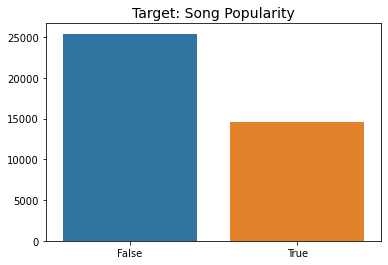

In [15]:
#| code-fold: true
sns.countplot(train.song_popularity.astype("bool"))
plt.title("Target: Song Popularity", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.show()

We find:

* There is a slight imbalance in the target distribution: a bit more than 60/40. Not super imbalanced, but something to keep in mind.

## 5. Feature interactions

After learning more about each individual feature, we now want to see them interacting with one another. It’s best to perfom those steps in that order, so that you can understand and interpret the interactions in the context of the overall distributions.

### 5.1. Target impact

We have seen all the feature distributions, now we want to investigate whether they look different based on the target value. Here’s an example for song_duration:

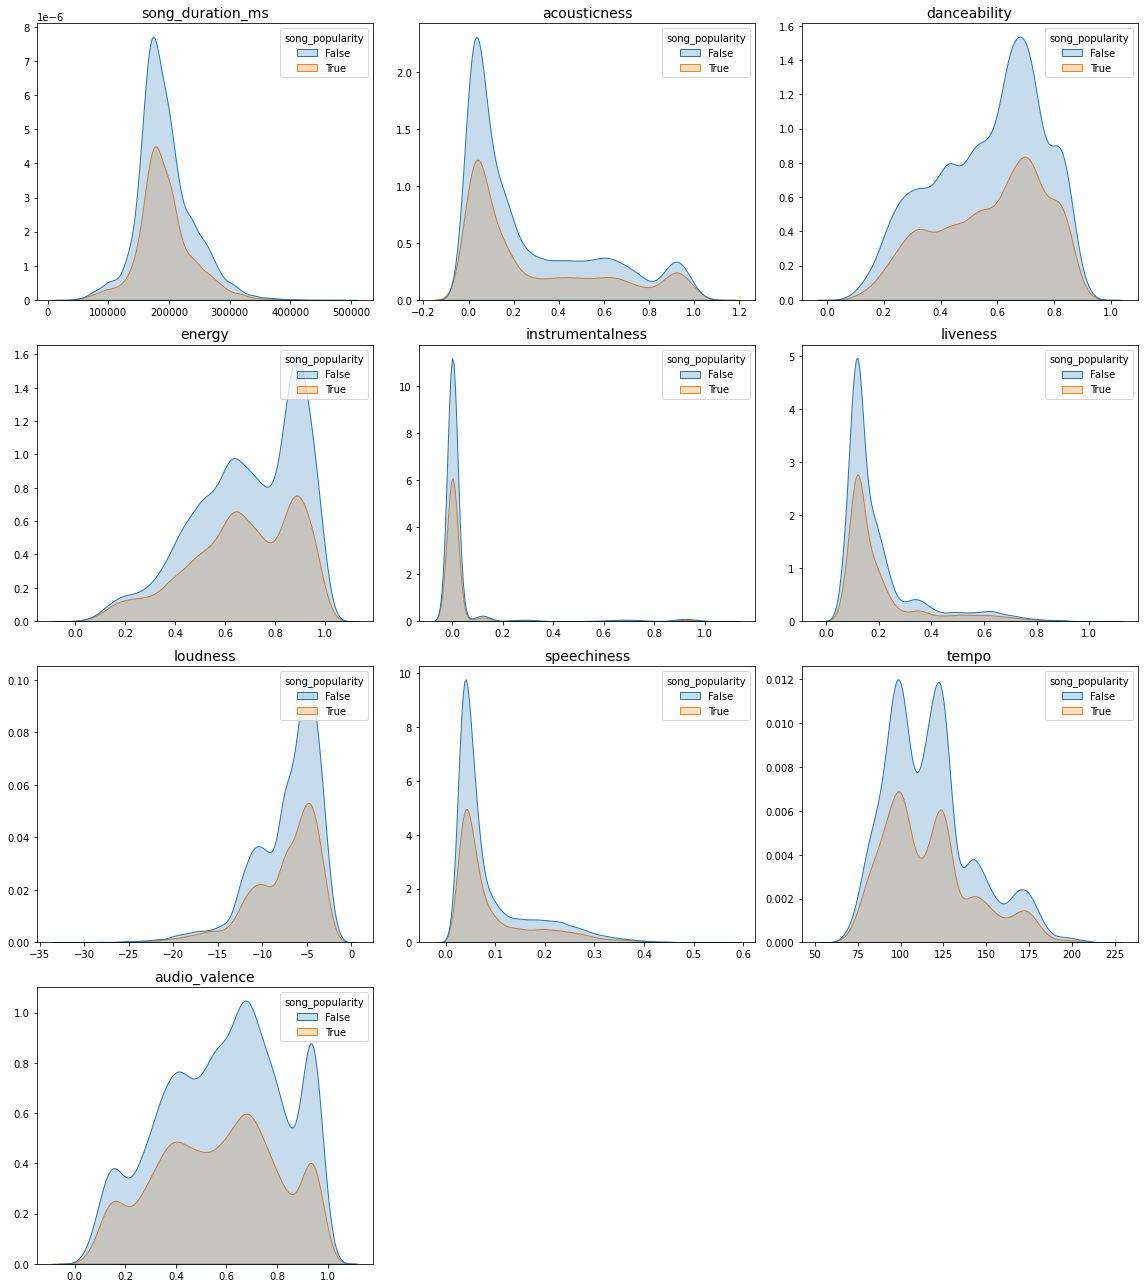

In [16]:
#| code-fold: true
fig = plt.figure(figsize=(16,18))
n_rows = 4
n_cols = 3

for index, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, index+1)
    
    sns.kdeplot(train[col], hue=train.song_popularity.astype("bool"), fill=True)
    plt.title(col, fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
plt.show()

Observations:

* By looking at the probability distribution of different variables we find that popular songs are almost exactly the same length as unpopular ones. There is a slight difference, but it’s pretty small.

Now we can check the categorical features.

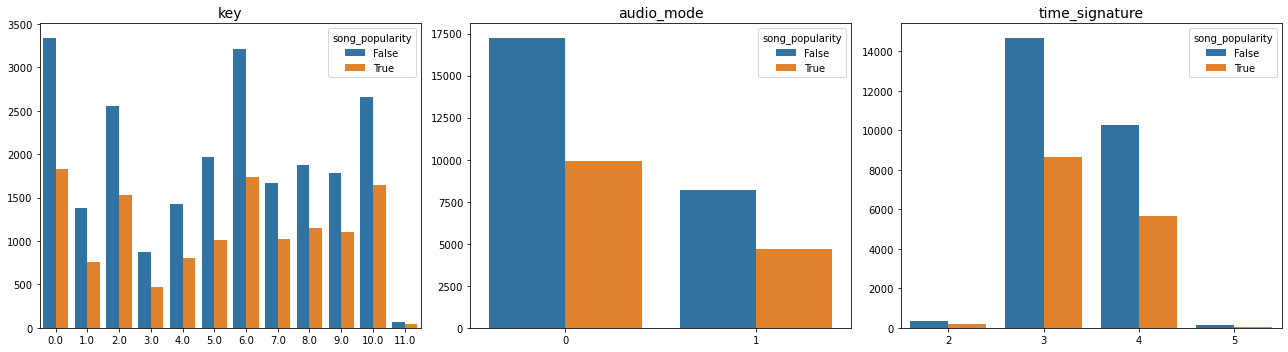

In [17]:
#| code-fold: true
fig = plt.figure(figsize=(18,5))

for index, col in enumerate(["key", "audio_mode", "time_signature"]):
    plt.subplot(1,3,index+1)
    
    sns.countplot(train[col], hue=train.song_popularity.astype("bool"))
    plt.title(col, fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
plt.show()

### 5.2. Feature Interaction

How do the predictor features interact with each other? Are there any redundancies or strong relationships? We will start out with a correlation matrix, and then look at features of interest in a bit more detail.

#### 5.2.1. Correlations overview

In [18]:
#| code-fold: true
# Refrence (edited): https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def heatmap(data):
    corr = pd.melt(data.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    x=corr['x']
    y=corr['y']
    size=corr['value'].abs()
    color=corr['value']
    
    fig, ax = plt.subplots(figsize=(10,10))
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    size_min, size_max = 0, 1
    
    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    def value_to_size(val):
        val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
        val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
        return val_position * size_scale
        
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size.apply(value_to_size), # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
        
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')
    
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right
    

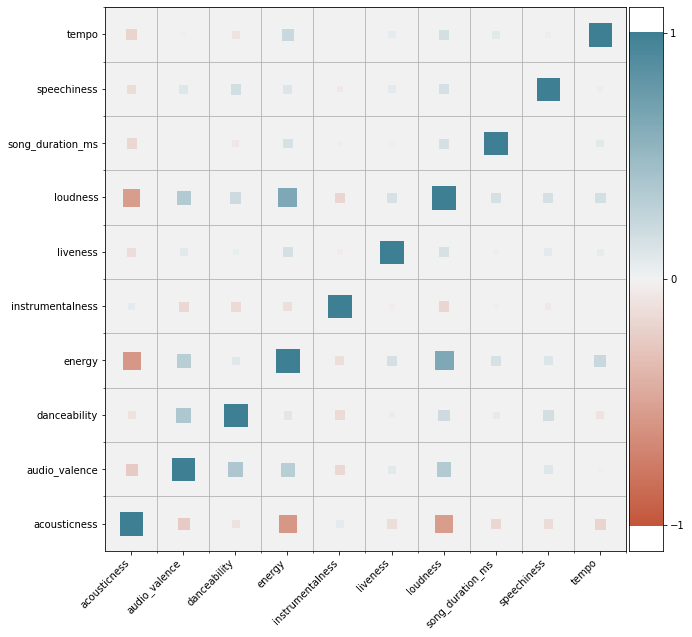

In [19]:
#| code-fold: true
heatmap(train[numeric_cols].corr())

Below is a similar correlation heatmap but only using the lower triangle to show the correlation.

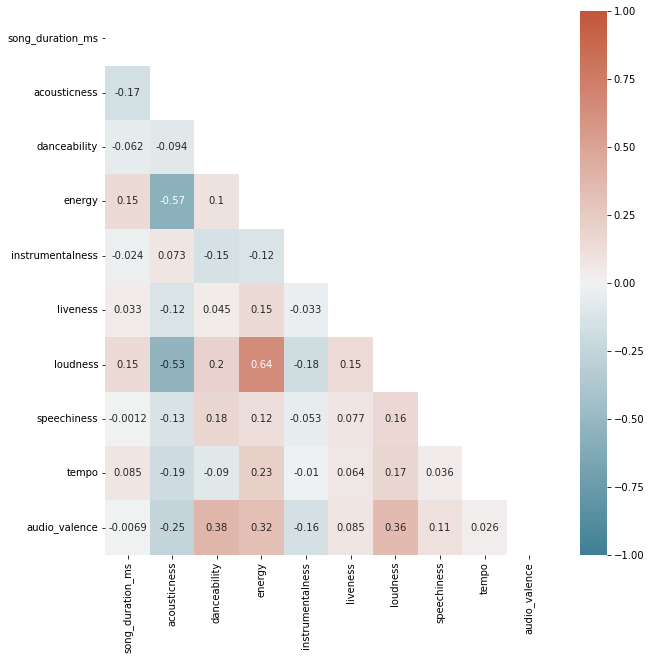

In [20]:
#| code-fold: true
# Refrence (edited): https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

fig = plt.figure(figsize=(10,10))
matrix = np.triu(np.ones_like(train[numeric_cols].corr(), dtype=np.bool))
sns.heatmap(train[numeric_cols].corr(), mask=matrix, vmin=-1, vmax=1, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

We find:

* There’s a strong anti-correlation between `acousticness` vs `energy` and `loudness`, respectively. Consequently, `energy` and `loudness` share a strong correlation.
* None of the features individually show a notable correlation with the target `song_popularity`.

#### 5.2.2. Categorical feature interactions

Whenever we’re looking at categorical features, we can assign a visualisation dimension like colour, size, or facets to those. We will start modifying our trusted density plots to look at the distributions of energy (potentially one of the more interesting numerical features) for the different values of time_signature (here encoded as colour):

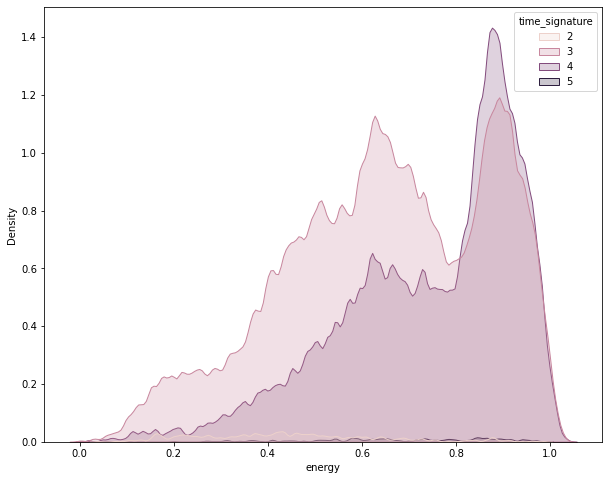

In [21]:
#| code-fold: true
fig = plt.figure(figsize=(10,8))
sns.kdeplot(x="energy", hue="time_signature", data=train, fill=True, bw=0.03)
plt.show()

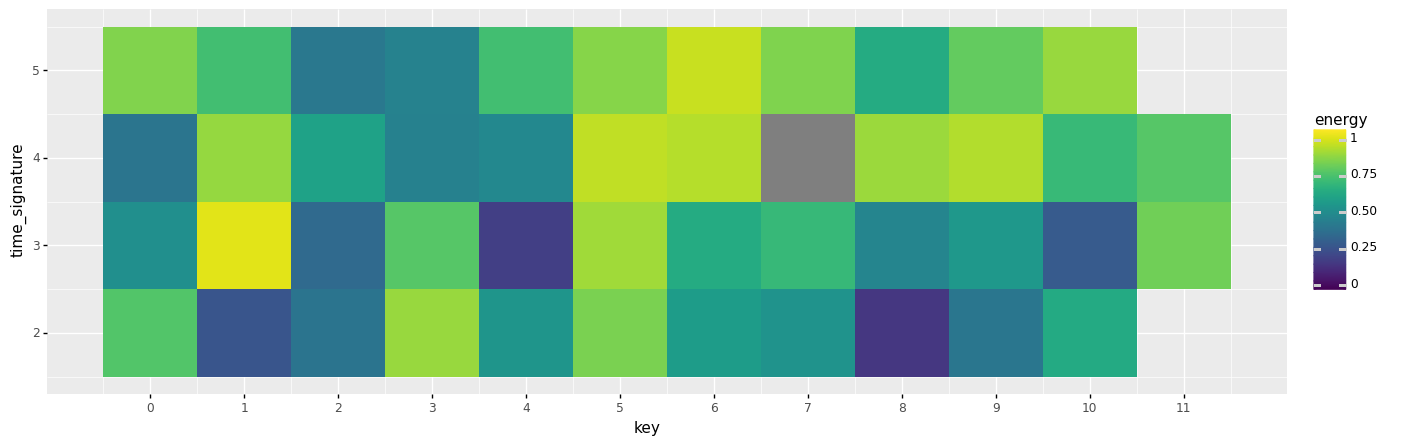

<ggplot: (8777952485729)>

In [22]:
#| code-fold: true
(ggplot(train, aes("key", "time_signature", fill = "energy")) 
 + geom_tile()
 + theme(figure_size=(16,5))
 + scale_x_continuous(breaks=range(0,12)))

We find:

* For time_signatures 2 and 5 we have no instances of key == 11. This is no big surprise, since those three values are already rare individually, which makes their combinations even more rare.
* There are no clear clusters of high vs low energy features here.
* We can see certain combinations that are particularly low energy, such as key == 2 and time_signature == 1 or 8. key == 3 and time_signature == 1 seems to be a particularly energetic combination.


### 5.3. Feature Target Interaction

Once we have found interesting correlations we can look for clustering in the target variable.

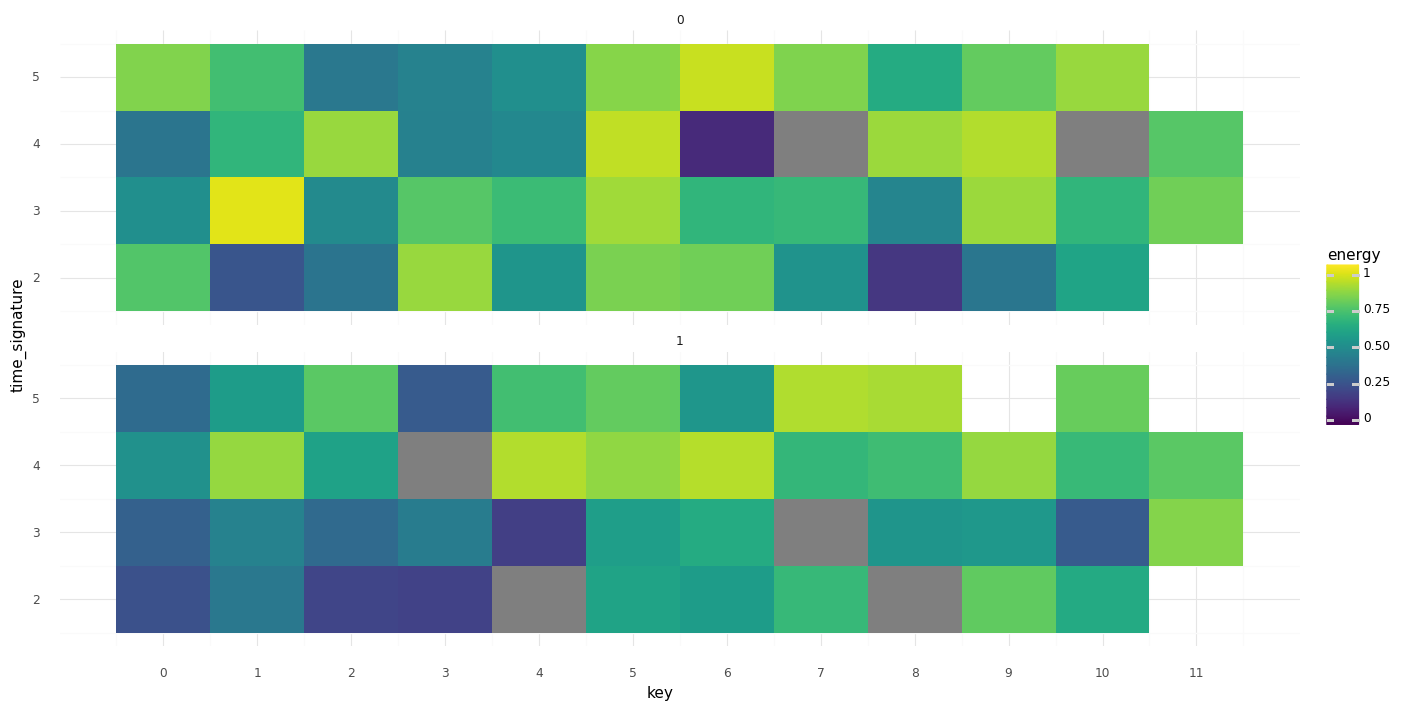

<ggplot: (8777950648995)>

In [24]:
#| code-fold: true
(ggplot(train, aes('key', 'time_signature')) 
 + geom_tile(aes(fill='energy')) 
 + facet_wrap("song_popularity", nrow = 2) 
 + theme_minimal() 
 + theme(figure_size=(16, 8))
 + scale_x_continuous(breaks=range(0,12)))

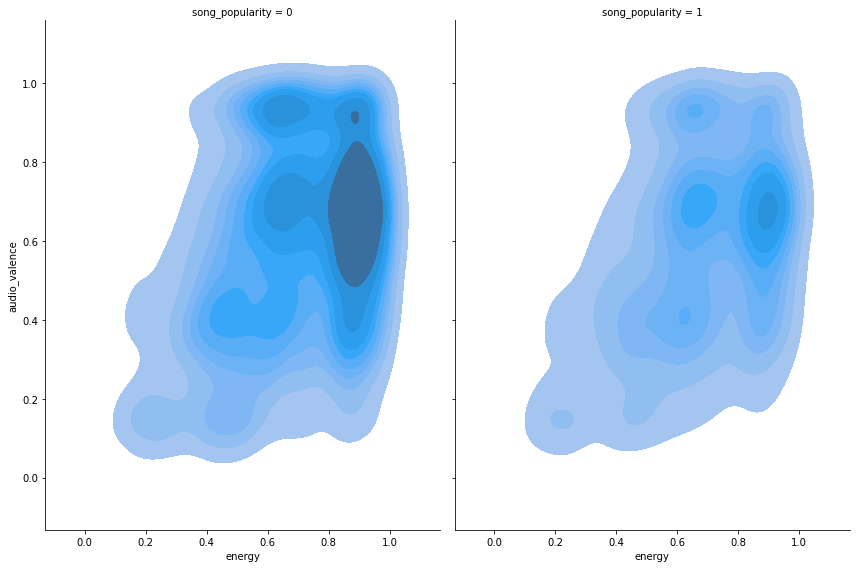

In [25]:
#| code-fold: true
sns.displot(data=train, x="energy", y="audio_valence", col="song_popularity", kind="kde", fill=True, legend=True, height=8, aspect=0.75)
plt.show()

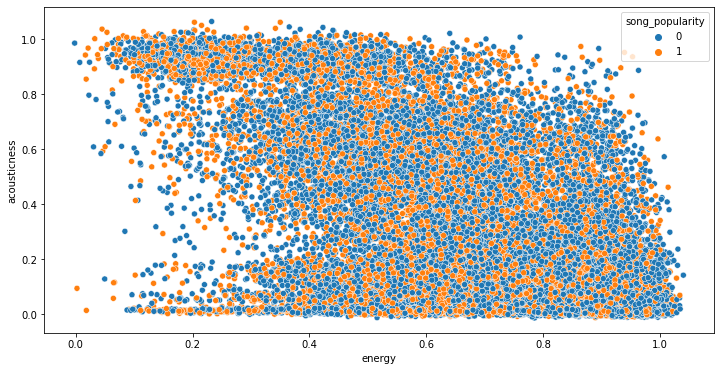

In [26]:
#| code-fold: true
fig = plt.figure(figsize=(12,6))
sns.scatterplot(x="energy", y="acousticness", hue="song_popularity", data=train)
plt.show()

### More Resources:
* [Choosing different color palette in Seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html#palette-tutorial)
* See also
    * [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid): Subplot grid for plotting pairwise relationships
    * [relplot](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot): Combine a relational plot and a FacetGrid
    * [displot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot): Combine a distribution plot and a FacetGrid
    * [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot): Combine a categorical plot and a FacetGrid
    * [lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot): Combine a regression plot and a FacetGrid

Special Thanks to [Martin Henze](https://www.kaggle.com/headsortails) for sharing his knowledge during the live coding session. Also, thank you [Abhishek Thakur](https://www.kaggle.com/abhishek) for hosting these wonderful sessions for people to learn. I look forward to learn more.

Share if you liked it, comment if you loved it. Hope to see you guys in the next one. Peace!